In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace, GenerationConfig
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', 'ansr-models', MODEL, CHECKPOINT),
    n_restarts=8,
    parsimony=0.3,
    device=device
)

In [4]:
demo_expression = [
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('0.1 * ((1.1 / x)**(12) - (1.2 / x)**6)', (0.1, 1.1, 1.2), (0.8, 2.5)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85)))', (5.3, 1, 0.72, 2.85), (-10, 10)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85))) + sin(1.5 * x)', (5.3, 1, 0.72, 2.85, 1.5), (-10, 10)),
][1]

In [5]:
expression, constants, xlim = demo_expression

In [6]:
prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [7]:
x = np.random.uniform(*xlim, 100)
y = demo_function(x)
if isinstance(y, float):
    y = np.full_like(x, y)

print(x.shape, y.shape)

(100,) (100,)


# Before

In [8]:
nsr.fit(
    x,
    y,
    verbose=True)

Fitting Constants: 100%|██████████| 32/32 [00:00<00:00, 322.69it/s]


In [9]:
nsr.get_expression()

'0.66 - cos(0.82 * x1)'

In [10]:
x_linspace = np.linspace(*xlim, 1000)
y_linspace_pred = nsr.predict(x_linspace.reshape(-1, 1))

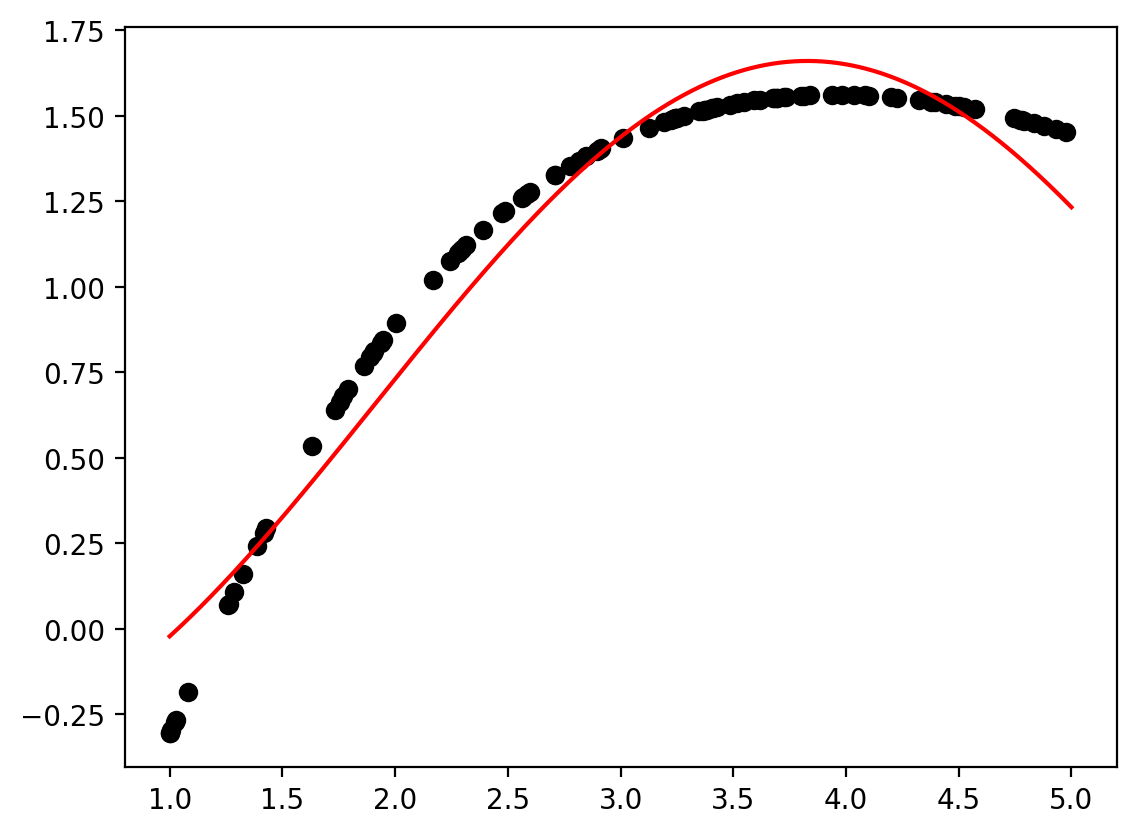

In [11]:
fig, ax = plt.subplots(dpi=200)

ax.scatter(x, y, label='Data', color='black')
ax.plot(x_linspace, y_linspace_pred, label='Prediction', color='red')

# Specialize

In [12]:
nsr.specialize(
    x,
    y,
    generation_config=GenerationConfig(method='softmax_sampling', temperature=1, top_p=0.95, choices=128),
    parsimony=0.3,
    verbose=True)

Specializing:   6%|▌         | 60/1000 [01:15<19:36,  1.25s/it, NLL=2.65e-02, H=5.46e-01, Max Queue Objective=-1.7, Min Queue Objective=-1.7, Min FVU=9.07e-06, Explored=2712, Best Expression=<num> * sin(<num> * pow1_3(<num> + x1))]       


KeyboardInterrupt: 

In [13]:
histories = {k: [log[k] for log in nsr.specialize_history] for k in nsr.specialize_history[0]}

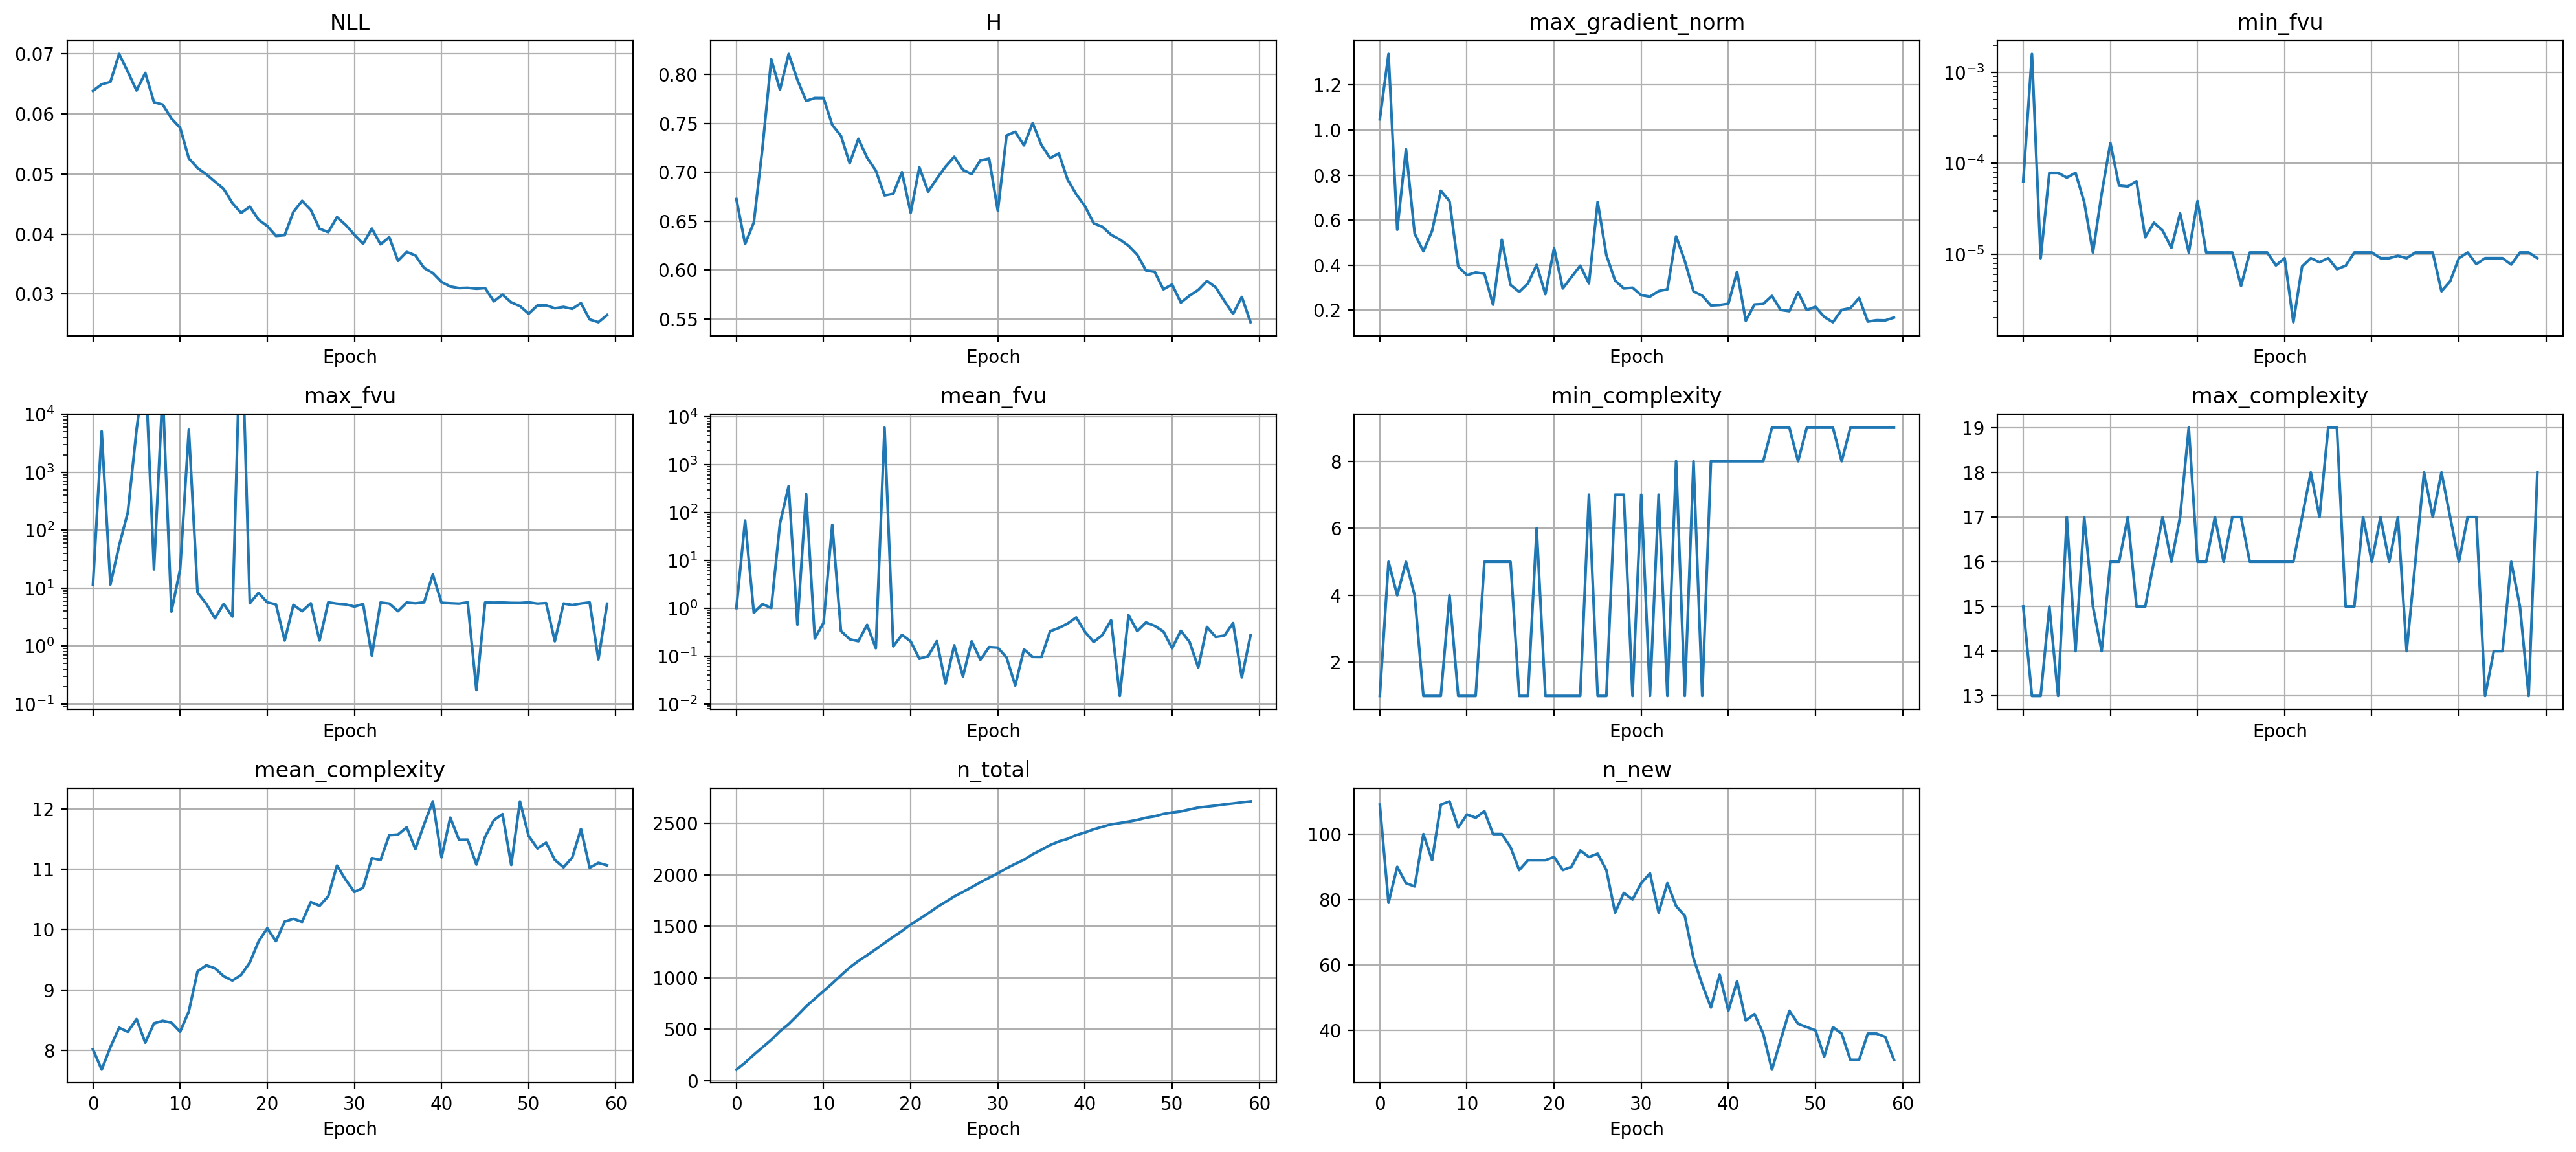

In [14]:
COLS = 4
ROWS = np.ceil(len(histories) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 3 * ROWS), dpi=200, sharex=True)

for ax, (k, v) in zip(axes.flat, histories.items()):
    valid_v = [x for x in v if np.isfinite(x)]
    ax.plot(range(len(v)), v)
    ax.set_xlabel('Epoch')
    ax.set_title(k)
    ax.grid()

    if 'fvu' in k:
        ax.set_yscale('log')

    if max(valid_v) > 10000:
        ax.set_ylim(None, 10000)

for ax in axes.flat[len(histories):]:
    ax.axis('off')

fig.tight_layout()

# After

In [15]:
nsr.fit(
    x,
    y,
    verbose=True)

Fitting Constants: 100%|██████████| 32/32 [00:00<00:00, 150.92it/s]


In [16]:
nsr.get_expression()

'sin(-3.0 * pow1_3(-0.06 + x1)) / 0.64'

In [17]:
x_linspace = np.linspace(*xlim, 1000)
y_linspace_pred = nsr.predict(x_linspace.reshape(-1, 1))

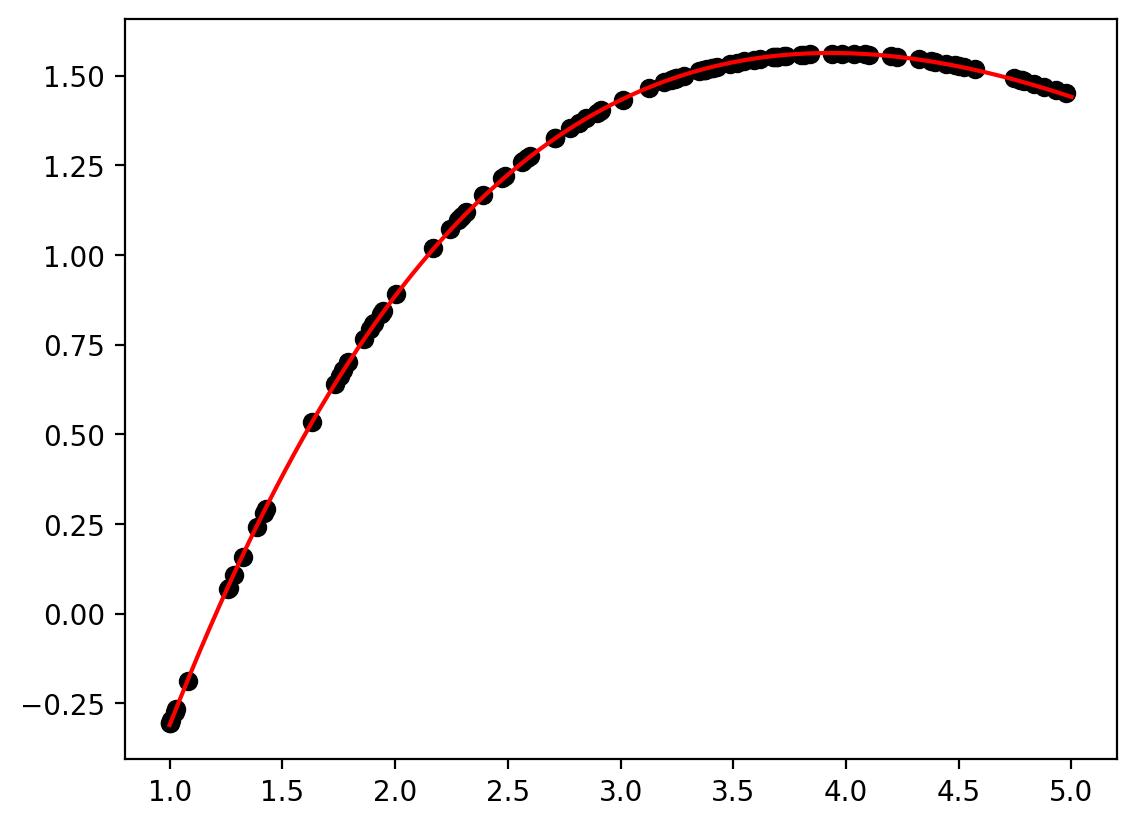

In [18]:
fig, ax = plt.subplots(dpi=200)

ax.scatter(x, y, label='Data', color='black')
ax.plot(x_linspace, y_linspace_pred, label='Prediction', color='red')

In [19]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,beam_id,fit_constants,fit_covariances,fit_loss
0,-3.597203,0.000038,-1.714785,"[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",9,None,None,"[1, 11, 22, 10, 6, 19, 7, 6, 30, 6, 2]","[11, 22, 10, 6, 19, 7, 6, 30, 6]","[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",<function <lambda> at 0x7f542952c5e0>,"Refiner(expression=['/', 'sin', '*', '<num>', ...",0,"[-3.0003774272505535, -0.05719296989290333, 0....","[[7.473288968635536e-07, 1.0808055830313859e-0...",0.000011
1,-3.597203,0.000038,-1.714785,"[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",9,None,None,"[1, 11, 22, 10, 6, 19, 7, 6, 30, 6, 2]","[11, 22, 10, 6, 19, 7, 6, 30, 6]","[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",<function <lambda> at 0x7f542952c5e0>,"Refiner(expression=['/', 'sin', '*', '<num>', ...",0,"[-0.8015733393740189, -1.001446121285502, -0.7...","[[0.02498297916354975, 4.3764574524081777e-10,...",0.080829
2,-3.597203,0.000038,-1.714785,"[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",9,None,None,"[1, 11, 22, 10, 6, 19, 7, 6, 30, 6, 2]","[11, 22, 10, 6, 19, 7, 6, 30, 6]","[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",<function <lambda> at 0x7f542952c5e0>,"Refiner(expression=['/', 'sin', '*', '<num>', ...",0,"[-1.0238608575754584, -1.0014461234265493, -0....","[[0.019013020471544774, 3.35476870716362e-10, ...",0.116613
3,-3.597203,0.000038,-1.714785,"[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",9,None,None,"[1, 11, 22, 10, 6, 19, 7, 6, 30, 6, 2]","[11, 22, 10, 6, 19, 7, 6, 30, 6]","[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",<function <lambda> at 0x7f542952c5e0>,"Refiner(expression=['/', 'sin', '*', '<num>', ...",0,"[-0.32618568042323787, -1.0014461260887042, -0...","[[0.5940889379679357, 1.792355745442112e-09, 0...",0.783227
4,-3.597203,0.000038,-1.714785,"[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",9,None,None,"[1, 11, 22, 10, 6, 19, 7, 6, 30, 6, 2]","[11, 22, 10, 6, 19, 7, 6, 30, 6]","[/, sin, *, <num>, pow1_3, +, <num>, x1, <num>]",<function <lambda> at 0x7f542952c5e0>,"Refiner(expression=['/', 'sin', '*', '<num>', ...",0,"[-0.010139348596660457, -1.299143408044099, 0....","[[inf, inf, inf], [inf, inf, inf], [inf, inf, ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,-5.848298,NaN,NaN,"[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",13,None,None,"[1, 10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 3...","[10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 30]","[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",<function <lambda> at 0x7f542951ae80>,"Refiner(expression=['*', '<num>', 'sin', '*', ...",31,"[-1.266129643005844, -0.4469861530347946, 1.32...","[[inf, inf, inf, inf, inf], [inf, inf, inf, in...",NaN
239,-5.848298,NaN,NaN,"[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",13,None,None,"[1, 10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 3...","[10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 30]","[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",<function <lambda> at 0x7f542951ae80>,"Refiner(expression=['*', '<num>', 'sin', '*', ...",31,"[-0.3068769539393627, 0.019548353168383933, -0...","[[inf, inf, inf, inf, inf], [inf, inf, inf, in...",NaN
240,-5.848298,NaN,NaN,"[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",13,None,None,"[1, 10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 3...","[10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 30]","[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",<function <lambda> at 0x7f542951ae80>,"Refiner(expression=['*', '<num>', 'sin', '*', ...",31,"[1.5587628240649913, 0.25713698503811655, 7.21...","[[6.952968492375026e-08, 0.0114184156116378, -...",0.000003
241,-5.848298,NaN,NaN,"[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",13,None,None,"[1, 10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 3...","[10, 6, 22, 10, 6, 10, 6, 7, 6, 29, 7, 6, 30]","[*, <num>, sin, *, <num>, *, <num>, +, <num>, ...",<function <lambda> at 0x7f542951ae80>,"Refiner(expression=['*', '<num>', 'sin',